# **Image Classification**

In this project, I conducted experiment to built classification model which is able to predict the 4 different image classes. Basically, the experiment process is separated into 2 steps, **image pre processing** and **model building**

## **1. Image preprocessing**

In this step, I read the image from image folders. Then, I construct it into tensor which is served as image data and image label.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import cv2
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score
from PIL import Image
from tqdm import tqdm

**a. Read, resize, and scale the image**

In this process, I have performed 3 steps, getting image, resizing, and scaling. I just used 500 images for each label because after trying to get all 8000+ images, I got the disconnected runtime due to the limitation of CPU RAM.

In [ ]:
# Read dataset
result = {}
for label in os.listdir("/content/drive/MyDrive/Study/Computer_Science/Project/Telkomsel_Recruitment/Image-Classification/image-classification/images/images"):
  label_path = f"/content/drive/MyDrive/Study/Computer_Science/Project/Telkomsel_Recruitment/Image-Classification/image-classification/images/images/{label}"
  for file in tqdm(os.listdir(label_path)):
    if (
        file.endswith(".png")
        or file.endswith(".jpg")
        or file.endswith(".jpeg")
    ):
      image_path = f"{label_path}/{file}"
      img = Image.open(image_path).convert("RGB")
      # Load image as array and scale it it
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])
      img_resized = transform(img)
      img_scaled = img_resized/255
      if label not in result.keys():
        result[label] = []
      result[label].append(img_scaled)
      if len(result[label]) == 500:
        break

  2%|▏         | 148/8782 [02:11<1:19:14,  1.82it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  6%|▌         | 499/8800 [02:56<48:48,  2.83it/s] 


In [ ]:
# Save the dataset for further process
torch.save(result,"/content/drive/MyDrive/Study/Computer_Science/Project/Telkomsel_Recruitment/Image-Classification/image-classification/dataset.pt")

**b. Constructing image dataset with appropriate labels**

In this process, I just simply concatenated each of label data and the label itself into 2 different arrays, the first array is for the image data and the second array is for label data

In [ ]:
# Reload the dataset
dataset = loaded_dict = torch.load("/content/drive/MyDrive/Study/Computer_Science/Project/Telkomsel_Recruitment/Image-Classification/image-classification/dataset.pt")

In [ ]:
# Construct label
# architecure = 0
# art and culture = 1
# food and drinks = 2
# travel and adventure = 3

label_data = np.concatenate([
    np.repeat(0, 500),
    np.repeat(1, 500),
    np.repeat(2, 500),
    np.repeat(3, 500)
])

# Construct image data
list_data = []
for label_name in dataset.keys():
  list_data += dataset[label_name]
all_data = np.array(list_data)

print(f"all_data = {all_data.shape}")
print(f"Label = {label_data.shape}")

all_data = (2000, 3, 224, 224)
Label = (2000,)


After aforementioned process done, we can see the total data is 2000, which is equal to the four times of 500 images.

**c. Splitting train and test dataset, also converting into tensor**

In this process, I splitted the image data into train and test set. I chose the test size of 0.2 because the total image is 2000, which is actually small, so I think using 20% of total data as test set will be wise.

In [ ]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(all_data, label_data, test_size=0.2)

In [ ]:
# Convert data into tensor
x_train_tensor = torch.from_numpy(x_train).to(torch.float)
x_test_tensor = torch.from_numpy(x_test).to(torch.float)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)
print(f"x_train = {x_train_tensor.size()}")
print(f"x_test = {x_test_tensor.size()}")
print(f"y_train = {y_train_tensor.size()}")
print(f"y_test = {y_test_tensor.size()}")

x_train = torch.Size([1600, 3, 224, 224])
x_test = torch.Size([400, 3, 224, 224])
y_train = torch.Size([1600])
y_test = torch.Size([400])


In [ ]:
# Create batch data with dataloader
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), shuffle=False, batch_size=32)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), shuffle=False, batch_size=32)

## **Modeling**

In this process, I didn't build the network from scratch, instead I utilize 2 different pre-trained model, which are ResNet50 and EfficientNetB0. Why I use pre-trained models instead of creating model from scratch? It is simply that the timeline of this project is very short and I have another technical test project (fraud detection), so I think it will be very wise to use pre-trained models.

Using pre-trained models such as ResNet50 and EfficientNetB0 is also very good I think since these models are trained before in ImageNet dataset. We can simply change the final layer into Linear layer with 4 dimensional output neurons (match with our image labels) and freeze all of other layers behind the final layer.

In [ ]:
# Import packages
from torchvision import models
from torchsummary import summary

**ResNet 50**

In [ ]:
resnet_model = models.resnet50(pretrained=True)

In [ ]:
# Change the final FC layer (unfreeze) and freeze the others
resnet_model.fc = nn.Linear(2048, 4, bias=True)

# Freezing layers
for name, module in resnet_model.named_children():
  if name != 'fc':
    for param in module.parameters():
      param.requires_grad = False
  else:
    param.requires_grad = True

In [ ]:
summary(resnet_model, (3,224,224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

On model summary above, we can see ResNet50 has 23 million parameters and we just train 8 thousand parameters (all layer except the final layer are freezed).

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = resnet_model
    self.softmax = nn.Softmax()
  def forward(self, input):
    output = self.resnet(input)
    output = self.softmax(output)
    return output

In [ ]:
# Define model
model_resnet = ResNet().to('cuda')

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.0001)

100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


Training Loss = 1.2297011613845825 | Training Acc = 0.78125 | Test Loss = 1.3820961713790894 | Test Acc = 0.3125




100%|██████████| 50/50 [00:05<00:00,  9.48it/s]


Training Loss = 1.0997682809829712 | Training Acc = 0.84375 | Test Loss = 1.2310302257537842 | Test Acc = 0.6875




100%|██████████| 50/50 [00:05<00:00,  9.32it/s]


Training Loss = 1.0271546840667725 | Training Acc = 0.84375 | Test Loss = 1.0502653121948242 | Test Acc = 0.8125




100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


Training Loss = 0.9826416373252869 | Training Acc = 0.875 | Test Loss = 1.0064005851745605 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.44it/s]


Training Loss = 0.9520809054374695 | Training Acc = 0.9375 | Test Loss = 0.9777168035507202 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


Training Loss = 0.9296845197677612 | Training Acc = 0.9375 | Test Loss = 0.9572049975395203 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.53it/s]


Training Loss = 0.91252201795578 | Training Acc = 0.9375 | Test Loss = 0.9419464468955994 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


Training Loss = 0.8988850712776184 | Training Acc = 0.9375 | Test Loss = 0.930256724357605 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


Training Loss = 0.8877352476119995 | Training Acc = 0.9375 | Test Loss = 0.9210814833641052 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.52it/s]


Training Loss = 0.8784225583076477 | Training Acc = 0.9375 | Test Loss = 0.9137269258499146 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.47it/s]


Training Loss = 0.870519757270813 | Training Acc = 0.96875 | Test Loss = 0.9077202081680298 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


Training Loss = 0.8637316226959229 | Training Acc = 0.96875 | Test Loss = 0.902730405330658 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


Training Loss = 0.8578431606292725 | Training Acc = 0.96875 | Test Loss = 0.8985208868980408 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.41it/s]


Training Loss = 0.8526920676231384 | Training Acc = 0.96875 | Test Loss = 0.8949195146560669 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.33it/s]


Training Loss = 0.8481526374816895 | Training Acc = 0.96875 | Test Loss = 0.8917990922927856 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Training Loss = 0.8441247940063477 | Training Acc = 0.96875 | Test Loss = 0.8890643119812012 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.26it/s]


Training Loss = 0.8405285477638245 | Training Acc = 0.96875 | Test Loss = 0.88664311170578 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Training Loss = 0.837299108505249 | Training Acc = 0.96875 | Test Loss = 0.8844794631004333 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.30it/s]


Training Loss = 0.834382951259613 | Training Acc = 0.96875 | Test Loss = 0.8825303316116333 | Test Acc = 0.875




100%|██████████| 50/50 [00:05<00:00,  9.35it/s]


Training Loss = 0.8317365646362305 | Training Acc = 0.96875 | Test Loss = 0.8807615041732788 | Test Acc = 0.875




Text(0.5, 1.0, 'Accuracy')

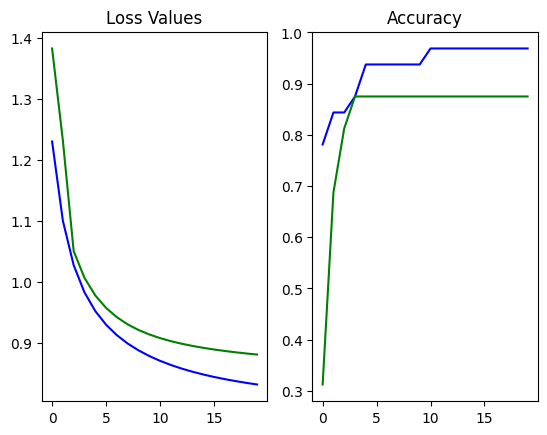

In [ ]:
import warnings
warnings.filterwarnings("ignore")
EPOCH = 20
training_loss = []
training_acc = []
test_loss = []
test_acc = []
for epoch in range(EPOCH):
  print(f"EPOCH {epoch+1}")
  model_resnet.train()
  for x_train_batch, y_train_batch in tqdm(train_loader):
    # Forward propagation
    x_train_batch = x_train_batch.to('cuda')
    prediction_train = model_resnet.forward(x_train_batch)
    prediction_train = prediction_train.to('cpu')
    loss_training = loss_fn(prediction_train, y_train_batch)

    # Back propagation
    optimizer.zero_grad()
    loss_training.backward()
    optimizer.step()

  # Loss value
  training_loss.append(loss_training.detach())
  # Accuracy value
  total_match = torch.sum(torch.argmax(prediction_train, 1) == y_train_batch)
  training_accuracy = total_match/len(prediction_train)
  training_accuracy = float(training_accuracy.numpy())
  training_acc.append(training_accuracy)

  # Evaluation
  model_resnet.eval()
  with torch.no_grad():
    for x_test_batch, y_test_batch in test_loader:
      x_test_batch = x_test_batch.to('cuda')
      prediction_test = model_resnet.forward(x_test_batch)
      prediction_test = prediction_test.to('cpu')
      loss_test = loss_fn(prediction_test, y_test_batch)

    # Loss value
    test_loss.append(loss_test.detach())
    # Accuracy value
    total_match = torch.sum(torch.argmax(prediction_test, 1) == y_test_batch)
    test_accuracy = total_match/len(prediction_test)
    test_accuracy = float(test_accuracy.numpy())
    test_acc.append(test_accuracy)

  print(f"Training Loss = {loss_training} | Training Acc = {training_accuracy} | Test Loss = {loss_test} | Test Acc = {test_accuracy}")
  print("\n")


plt.subplot(1,2,1)
plt.plot(list(range(EPOCH)), training_loss, label="training loss", color = "b")
plt.plot(list(range(EPOCH)), test_loss, label="test loss", color = "g")
plt.title("Loss Values")
plt.subplot(1,2,2)
plt.plot(list(range(EPOCH)), training_acc, label="training accuracy", color = "b")
plt.plot(list(range(EPOCH)), test_acc, label="test acc", color = "g")
plt.title("Accuracy")

From the loss and accuracy values, we can see that this model performs really well with just 2000 data in 20 epochs training. I can't train again with GPU due to the GPU limitation from google colab (If training is conducted with CPU, the process is quite long). But I think this accuracy and loss will be more good if we can train in more longer epochs.

**EfficientNet B0**

In this experiment using EfficientNetB0, I performed the same thing as I did on ResNet50.

In [ ]:
model_efficient_net = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


In [ ]:
# Change the final layer
model_efficient_net.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True)

# Freezing layers
for name, module in model_efficient_net.named_children():
  if name != 'classifier':
    for param in module.parameters():
      param.requires_grad = False
  else:
    for idx, param in enumerate(model_efficient_net.classifier):
      if idx == 1:
        param.requires_grad = True
      else:
        param.requires_grad = False

In [ ]:
summary(model_efficient_net, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In this model parameters, we can see the resnet parameters are lower than ResNet50.

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.efficientnet = model_efficient_net
    self.softmax = nn.Softmax()
  def forward(self, input):
    output = self.efficientnet(input)
    output = self.softmax(output)
    return output

In [ ]:
# Define model
model_efficient_net = EfficientNet().to('cuda')

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficient_net.parameters(), lr=0.0001)

EPOCH 1


100%|██████████| 50/50 [00:03<00:00, 12.62it/s]


Training Loss = 1.3544716835021973 | Training Acc = 0.53125 | Test Loss = 1.3899229764938354 | Test Acc = 0.0625


EPOCH 2


100%|██████████| 50/50 [00:02<00:00, 20.11it/s]


Training Loss = 1.2936336994171143 | Training Acc = 0.65625 | Test Loss = 1.3447355031967163 | Test Acc = 0.3125


EPOCH 3


100%|██████████| 50/50 [00:02<00:00, 20.17it/s]


Training Loss = 1.2424999475479126 | Training Acc = 0.78125 | Test Loss = 1.227216124534607 | Test Acc = 0.75


EPOCH 4


100%|██████████| 50/50 [00:02<00:00, 20.31it/s]


Training Loss = 1.1996426582336426 | Training Acc = 0.84375 | Test Loss = 1.1838568449020386 | Test Acc = 0.75


EPOCH 5


100%|██████████| 50/50 [00:02<00:00, 20.56it/s]


Training Loss = 1.147429347038269 | Training Acc = 0.875 | Test Loss = 1.1482131481170654 | Test Acc = 0.75


EPOCH 6


100%|██████████| 50/50 [00:02<00:00, 20.06it/s]


Training Loss = 1.1300641298294067 | Training Acc = 0.84375 | Test Loss = 1.1190662384033203 | Test Acc = 0.75


EPOCH 7


100%|██████████| 50/50 [00:02<00:00, 19.78it/s]


Training Loss = 1.094294786453247 | Training Acc = 0.90625 | Test Loss = 1.0938236713409424 | Test Acc = 0.75


EPOCH 8


100%|██████████| 50/50 [00:02<00:00, 20.81it/s]


Training Loss = 1.0673279762268066 | Training Acc = 0.90625 | Test Loss = 1.0735684633255005 | Test Acc = 0.75


EPOCH 9


100%|██████████| 50/50 [00:02<00:00, 19.42it/s]


Training Loss = 1.0470693111419678 | Training Acc = 0.875 | Test Loss = 1.0583751201629639 | Test Acc = 0.75


EPOCH 10


100%|██████████| 50/50 [00:02<00:00, 20.50it/s]


Training Loss = 1.0261186361312866 | Training Acc = 0.875 | Test Loss = 1.043038249015808 | Test Acc = 0.75


EPOCH 11


100%|██████████| 50/50 [00:02<00:00, 20.06it/s]


Training Loss = 1.015802025794983 | Training Acc = 0.875 | Test Loss = 1.0327447652816772 | Test Acc = 0.8125


EPOCH 12


100%|██████████| 50/50 [00:02<00:00, 21.01it/s]


Training Loss = 0.994796633720398 | Training Acc = 0.875 | Test Loss = 1.0217890739440918 | Test Acc = 0.8125


EPOCH 13


100%|██████████| 50/50 [00:02<00:00, 20.43it/s]


Training Loss = 0.9844626784324646 | Training Acc = 0.90625 | Test Loss = 1.0128880739212036 | Test Acc = 0.8125


EPOCH 14


100%|██████████| 50/50 [00:02<00:00, 20.25it/s]


Training Loss = 0.9666385650634766 | Training Acc = 0.90625 | Test Loss = 1.0053642988204956 | Test Acc = 0.8125


EPOCH 15


100%|██████████| 50/50 [00:02<00:00, 19.82it/s]


Training Loss = 0.9629641771316528 | Training Acc = 0.90625 | Test Loss = 0.9983636140823364 | Test Acc = 0.8125


EPOCH 16


100%|██████████| 50/50 [00:02<00:00, 19.76it/s]


Training Loss = 0.9511095285415649 | Training Acc = 0.90625 | Test Loss = 0.9929524064064026 | Test Acc = 0.8125


EPOCH 17


100%|██████████| 50/50 [00:02<00:00, 20.71it/s]


Training Loss = 0.9697095155715942 | Training Acc = 0.875 | Test Loss = 0.9865179657936096 | Test Acc = 0.8125


EPOCH 18


100%|██████████| 50/50 [00:02<00:00, 20.30it/s]


Training Loss = 0.9412479400634766 | Training Acc = 0.90625 | Test Loss = 0.9812501668930054 | Test Acc = 0.8125


EPOCH 19


100%|██████████| 50/50 [00:02<00:00, 17.31it/s]


Training Loss = 0.9362868070602417 | Training Acc = 0.90625 | Test Loss = 0.9768690466880798 | Test Acc = 0.8125


EPOCH 20


100%|██████████| 50/50 [00:02<00:00, 19.85it/s]


Training Loss = 0.9388538599014282 | Training Acc = 0.90625 | Test Loss = 0.9714066982269287 | Test Acc = 0.8125




Text(0.5, 1.0, 'Accuracy')

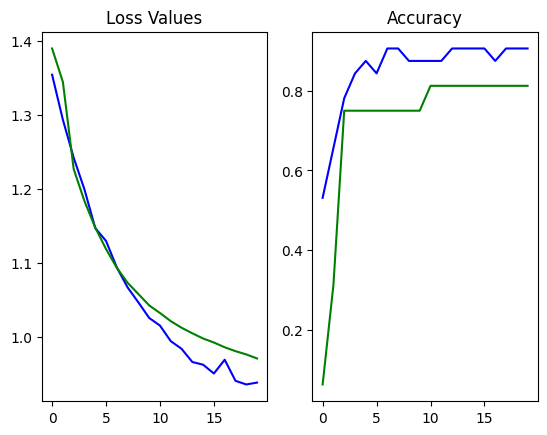

In [ ]:
import warnings
warnings.filterwarnings("ignore")
EPOCH = 20
training_loss = []
training_acc = []
test_loss = []
test_acc = []
for epoch in range(EPOCH):
  print(f"EPOCH {epoch+1}")
  model_efficient_net.train()
  for x_train_batch, y_train_batch in tqdm(train_loader):
    # Forward propagation
    x_train_batch = x_train_batch.to('cuda')
    prediction_train = model_efficient_net.forward(x_train_batch)
    prediction_train = prediction_train.to('cpu')
    loss_training = loss_fn(prediction_train, y_train_batch)

    # Back propagation
    optimizer.zero_grad()
    loss_training.backward()
    optimizer.step()

  # Loss value
  training_loss.append(loss_training.detach())
  # Accuracy value
  total_match = torch.sum(torch.argmax(prediction_train, 1) == y_train_batch)
  training_accuracy = total_match/len(prediction_train)
  training_accuracy = float(training_accuracy.numpy())
  training_acc.append(training_accuracy)

  # Evaluation
  model_efficient_net.eval()
  with torch.no_grad():
    for x_test_batch, y_test_batch in test_loader:
      x_test_batch = x_test_batch.to('cuda')
      prediction_test = model_efficient_net.forward(x_test_batch)
      prediction_test = prediction_test.to('cpu')
      loss_test = loss_fn(prediction_test, y_test_batch)

    # Loss value
    test_loss.append(loss_test.detach())
    # Accuracy value
    total_match = torch.sum(torch.argmax(prediction_test, 1) == y_test_batch)
    test_accuracy = total_match/len(prediction_test)
    test_accuracy = float(test_accuracy.numpy())
    test_acc.append(test_accuracy)

  print(f"Training Loss = {loss_training} | Training Acc = {training_accuracy} | Test Loss = {loss_test} | Test Acc = {test_accuracy}")
  print("\n")


plt.subplot(1,2,1)
plt.plot(list(range(EPOCH)), training_loss, label="training loss", color = "b")
plt.plot(list(range(EPOCH)), test_loss, label="test loss", color = "g")
plt.title("Loss Values")
plt.subplot(1,2,2)
plt.plot(list(range(EPOCH)), training_acc, label="training accuracy", color = "b")
plt.plot(list(range(EPOCH)), test_acc, label="test acc", color = "g")
plt.title("Accuracy")

# **Conclusion**

The image classification model has been created with two different models, which are ResNet50 and EfficientNetB0. These two models result a good accuracy and loss for each training and testing.

1.   For ResNet50, the result is higher than EfficientNetB0 but it has quite large number of parameters (25 millions). So if the case needs high accuracy, we can leverage the model such as ResNet50 or even models with large number of parameters.
2.   For EfficientNetB0, the result is still high, but slightly lower than ResNet50. It makes sense since the total parameters of this model is just 4 millions. If the case needs the model to be implemented in lightweight devices, so this model can be a solution since its accuracy and loss is just slightly lower than the ResNet50.

